In [16]:
from data import InkmlDataset_PL
from models.lstm_ctc import LSTM_TemporalClassification_PL
# from torchaudio.models.decoder import ctc_decoder
import matplotlib.pyplot as plt
import numpy as np
from data import *

model = LSTM_TemporalClassification_PL(hidden_size=512, bidirectional=True).load_from_checkpoint("logs/lstm_ctc/version_0/checkpoints/epoch=35-step=32040.ckpt")
dm = InkmlDataset_PL(root_dir="dataset/crohme2019")
dm.setup()
# Set the model to evaluation mode
model.eval()


LSTM_TemporalClassification_PL(
  (model): LSTM_TemporalClassification(
    (lstm): LSTM(3, 512, num_layers=2, batch_first=True)
    (fc): Linear(in_features=512, out_features=109, bias=True)
    (log_softmax): LogSoftmax(dim=2)
  )
  (criterion): CTCLoss()
)

In [ ]:
tokens = list(model.vocab.keys())
beam_search = ctc_decoder(
    lexicon=None,
    tokens=tokens,
    nbest=1,
    blank_token=0
)

In [115]:
# x, y, lenx, leny = dm.test_dataset.__getitem__(0)
path = 'dataset/crohme2019/crohme2019/test/ISICal19_1207_em_844.inkml'
ink = Inkml(path)

traces = ink.getTraces()
delta_traces = []
pen_up = []
for trace in traces:
    trace = (
        np.vstack([np.array(trace), np.array(trace)])
        if len(trace) == 1
        else trace
    )
    delta_trace = np.diff(trace, axis=0)
    delta_traces.append(delta_trace[:, :2])
    pen_up.append(np.zeros((len(delta_trace), 1)))
    pen_up[-1][-1] = 1

combined_traces = np.hstack([np.vstack(delta_traces), np.concatenate(pen_up)])
delta_traces_tensor = torch.tensor(combined_traces, dtype=torch.float32)

output = model(delta_traces_tensor.unsqueeze(0).cuda())

c \cos Right ( Right n Right 2 Right ) 

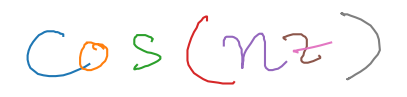

In [116]:
normal_prob = np.exp(output.squeeze(0).cpu().detach().numpy())

argmax = np.argmax(normal_prob, axis=1)
argmax = [tokens[i] for i in argmax if i != 0]
for i in argmax:
    print(i, end=" ")

# print([np.array(trace)[:, :2].shape for trace in ink.getTraces()])

plt.figure(figsize=(5,1))
plt.rcParams['axes.facecolor'] = 'black'  # Set background color to black
plt.axis('off')
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], - trace_arr[:, 1]) # invert y coordinate